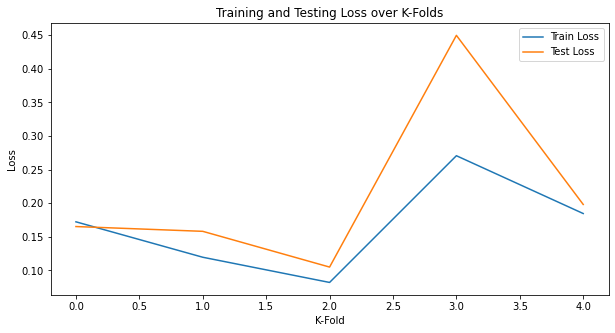

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

# 1. 读取Excel文件
file_path = 'S50MC6_2.xlsx'
df = pd.read_excel(file_path)

# 2. 数据预处理
# 将需要的输入特征和目标值提取出来
X = df[["L1 Power (kW)", "L1 Speed (r/min)", "SFOC at nominal MCR (g/kWh)", "Power(kW)", "Speed(r/min)", "MCR"]]
# X = df[["Power(kW)", "Speed(r/min)", "MCR"]]
y = df[["SFOC"]]  # 预测的目标值

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. K折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_losses = []
test_losses = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]

    # 转换数据为PyTorch张量
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # 4. 构建全连接神经网络模型
    class NeuralNetwork(nn.Module):
        def __init__(self, input_size, output_size):
            super(NeuralNetwork, self).__init__()
            self.fc1 = nn.Linear(input_size, 64)
            self.fc2 = nn.Linear(64, 32)
            self.fc3 = nn.Linear(32, output_size)
            self.relu = nn.ReLU()

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # 初始化模型
    input_size = X_train.shape[1]
    output_size = y_train.shape[1]
    model = NeuralNetwork(input_size, output_size)

    # 5. 定义损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 6. 训练模型
    epochs = 20000
    for epoch in range(epochs):
        model.train()

        # 前向传播
        y_pred_train = model(X_train_tensor)
        loss = criterion(y_pred_train, y_train_tensor)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 7. 测试模型
    model.eval()
    y_pred_test = model(X_test_tensor)
    test_loss = criterion(y_pred_test, y_test_tensor)

    # 记录训练和测试的损失
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

# 8. 绘制训练和测试误差曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss over K-Folds')
plt.xlabel('K-Fold')
plt.ylabel('Loss')
plt.legend()
plt.show()